<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

This live sessions will continues where the previous live session on hacker statistics left off. These sessions serve to review the concepts of statistical inference laid out in Statistical Thinking in Python I and II. The goal is to reinforce the concepts and techniques of statistical inference using hacker stats to help students gain confidence applying them to new data analysis tasks.

In this live session, we will:

- Review concepts behind null hypothesis significance tests (NHSTs).
- Construct confidence intervals and perform NHSTs comparing two treatments in a data set.
- Compute confidence intervals on two-dimensional data sets, investigating correlations and linear regressions.

## **Necessary packages**

I always import my packages at the top of a notebook or `.py` file. It is good style.

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Seed RNG
np.random.seed(3252)

# I want crisp graphics, so we'll output SVG
%config InlineBackend.figure_format = 'svg'

## **The Dataset**

As a reminder, the data set we will be working with comes from a study by [Beattie, et al.](https://doi.org/10.1098/rsos.160321) in which they used the [Glasgow Facial Matching Test](https://en.wikipedia.org/wiki/Glasgow_Face_Matching_Test) (GFMT, [original paper](https://doi.org/10.3758/BRM.42.1.286)) to investigate how sleep deprivation affects a human subject's ability to match faces, as well as the confidence the subject has in those matches. Briefly, the test works by having subjects look at a pair of faces. Two such pairs are shown below.

<p align="center">
<img src="https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/assets/gfmt_faces.png?raw=True" alt="GFMT faces" width="400px">
</p>
<br>


For each of 40 pairs of faces, the subject gets as much time as he or she needs and then says whether or not they are the same person. The subject then rates his or her confidence in the choice.

In this study, subjects also took surveys to determine properties about their sleep. The surveys provide three different metric of sleep quality and wakefulness. 

- The Sleep Condition Indicator (SCI) is a measure of insomnia disorder over the past month. High scores indicate better sleep and scores of 16 and below indicate insomnia. 
- The Pittsburgh Sleep Quality Index (PSQI) quantifies how well a subject sleeps in terms of interruptions, latency, etc. A higher score indicates poorer sleep. 
- The Epworth Sleepiness Scale (ESS) assesses daytime drowsiness. Higher scores indicate greater drowsiness.

We will explore how the various sleep metrics are related to each other and how sleep disorders affect subjects' ability to discern faces and their confidence in doing so.

### Loading in the data set

We will load in the data set as in the previous live sesson on hacker stats.

In [2]:
# Read in the dataset
df = pd.read_csv(
    "https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/data/gfmt_sleep.csv?raw=True",
    na_values="*",
)

# Print header
df.head()

,participant number,gender,age,correct hit percentage,correct reject percentage,percent correct,confidence when correct hit,confidence when incorrect hit,confidence when correct reject,confidence when incorrect reject,confidence when correct,confidence when incorrect,sci,psqi,ess
0,8,f,39,65,80,72.5,91.0,90.0,93.0,83.5,93.0,90.0,9,13,2
1,16,m,42,90,90,90.0,75.5,55.5,70.5,50.0,75.0,50.0,4,11,7
2,18,f,31,90,95,92.5,89.5,90.0,86.0,81.0,89.0,88.0,10,9,3
3,22,f,35,100,75,87.5,89.5,NaN,71.0,80.0,88.0,80.0,13,8,20
4,27,f,74,60,65,62.5,68.5,49.0,61.0,49.0,65.0,49.0,13,9,12


For this session, we are particularly interested in the following columns:

- `percent correct`: Percentage of correct responses among all trials
- `confidence when correct`: Average confidence when the subject gave a correct response for for all trials
- `confidence when incorrect`: Average confidence when the subject gave a correct response for for all trials
- `sci`: The subject's Sleep Condition Indicator.
- `psqi`: The subject's Pittsburgh Sleep Quality Index.
- `ess`: The subject's Epworth Sleepiness Scale.

Going forward, it will be useful to separate the subjects into two groups, insomniacs and normal sleepers. We will therefore add an `'insomnia'` column to the DataFrame with True/False entries. Recall that a person is deemed an insomniac if their SCI is 16 or below.

In [3]:
# Add a column to the data frame for insomnia
df['insomnia'] = df['sci'] <= 16

With our data set in place, we can get moving with statistical inference.

## **Our approach**

In this live session, we will address the following questions.

2. How different is *confidence* in facial matching for insomniacs versus normal sleepers?
3. How are the different sleep metrics correlated?
4. How do sleep metric *correlate* with facial matching performance?

Along the way, we will introduce the necessary theoretical and technical concepts.

### **Function from the previous session**

We laid a lot of the groundwork we need in this live session in the previous one. We wrote functions and defined classes that are useful for our hacker stats approaches to inference. Here are the functions and class we wrote last time.

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n + 1) / n

    return x, y


def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))

    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw `size` bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


def plot_conf_ints(confints, palette=None):
    """Plot confidence intervals with estimates."""
    # Set a nice color palette
    if palette is None:
        palette = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
    elif type(palette) == str:
        palette = [palette]

    cats = [ci.category for ci in confints][::-1]
    estimates = [ci.estimate for ci in confints][::-1]
    conf_intervals = [ci.conf_int for ci in confints][::-1]
    palette = palette[: len(cats)][::-1]

    # Set up axes for plot
    fig, ax = plt.subplots(figsize=(5, len(cats) / 2))

    # Plot estimates as dots and confidence intervals as lines
    for i, (cat, est, conf_int) in enumerate(
        zip(cats, estimates, conf_intervals)
    ):
        color = palette[i % len(palette)]
        ax.plot(
            [est],
            [cat],
            marker=".",
            linestyle="none",
            markersize=10,
            color=color,
        )

        ax.plot(conf_int, [cat] * 2, linewidth=3, color=color)

    # Make sure margins look ok
    ax.margins(y=0.25 if len(cats) < 3 else 0.125)

    return ax


class ConfInt1D(object):
    """Class for computing and storing confidence intervals from
    one-dimensional data."""

    def __init__(
        self, data, func, ptiles=(2.5, 97.5), n_bs_reps=10000, category=None
    ):
        # Store data and settings
        self.data = data
        self.func = func
        self.ptiles = ptiles
        self.n_bs_reps = n_bs_reps
        self.category = category

        # Compute ECDF x and y values
        self.ecdf_x, self.ecdf_y = ecdf(self.data)

        # Compute plug-in estimate
        self.estimate = func(data)

        # Compute bootstrap confidence interval
        self.bs_reps = draw_bs_reps(data, func, size=n_bs_reps)
        self.conf_int = np.percentile(self.bs_reps, ptiles)

We are now all set to move on to analysis of how confidence subjects are in their answers for the face matching tests.

## **2. Confidence of insomniacs versus normal sleepers**

We saw in the first live session that there seems to be a difference in performance between normal sleepers and insomniacs. Now, let's compare how well the subjects *think* they are doing in their responses. We will investigate their confidence when correct and incorrect in the face matching tasks for both insomniacs and normal sleepers. We start by extracting the measurements from the DataFrame as NumPy arrays.

In [5]:
# Extract confidences for normal sleepers
conf_corr_normal = (
    df.loc[~df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_normal = (
    df.loc[~df["insomnia"], "confidence when incorrect"].dropna().values
)

# Extract confidences for insomniacs
conf_corr_insom = (
    df.loc[df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_insom = (
    df.loc[df["insomnia"], "confidence when incorrect"].dropna().values
)

### **Performing the analysis (the automated way)**

The analysis pipeline is much the same as we did for looking at the percent correct in the first lesson. We will again compute means and confidence intervals of the mean. We can conveniently use our `ConfInt1D` class to do all of the calculations.

In [6]:
# Put into classes
conf_corr_normal = ConfInt1D(
    conf_corr_normal, np.mean, category="normal when correct",
)
conf_incorr_normal = ConfInt1D(
    conf_incorr_normal, np.mean, category="normal when incorrect",
)
conf_corr_insom = ConfInt1D(
    conf_corr_insom, np.mean, category="insomniac when correct"
)
conf_incorr_insom = ConfInt1D(
    conf_incorr_insom, np.mean, category="insomniac when incorrect"
)

### **EDA**

While we did just compute confidence intervals, we should always do a bit of EDA to check things out. We will plot the ECDFs of all four classes (confidence when correct and incorrect for normal sleepers and insomniacs) and overlay them on the same plot.

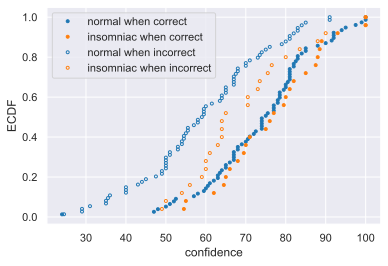

In [7]:
# Dictionary of kwargs for convenience
kwargs = {'marker': '.', 'linestyle': 'none'}

# Plot ECDFs
_ = plt.plot(
    conf_corr_normal.ecdf_x,
    conf_corr_normal.ecdf_y,
    color="#1f77b3",
    label=conf_corr_normal.category,
    **kwargs,
)
_ = plt.plot(
    conf_corr_insom.ecdf_x,
    conf_corr_insom.ecdf_y,
    color="#ff7f0e",
    label=conf_corr_insom.category,
    **kwargs,
)
_ = plt.plot(
    conf_incorr_normal.ecdf_x,
    conf_incorr_normal.ecdf_y,
    color="#1f77b3",
    fillstyle="none",
    label=conf_incorr_normal.category,
    **kwargs,
)
_ = plt.plot(
    conf_incorr_insom.ecdf_x,
    conf_incorr_insom.ecdf_y,
    color="#ff7f0e",
    fillstyle="none",
    label=conf_incorr_insom.category,
    **kwargs,
)

# Adjust labels
_ = plt.xlabel("confidence")
_ = plt.ylabel("ECDF")
_ = plt.legend()

We see a few striking trends directly from the ECDF.

1. Regardless of sleep quality, subjects are less confident in their responses when they are wrong.
2. When they are right, insomniacs and normal sleepers seem to have the same level of confidence in their responses.
3. When they are wrote, insomniacs have more confidence in their responses than normal sleepers.

This last point is really interesting. The insomniacs seem less likely to *know when they are wrong.* This kind of cognitive impairment could have real repercussions in how they go about their lives. We will give this last difference special attention.

### **Plug-in estimates and confidence intervals**

We have already computed the plug-in estimates for the mean and confidence intervals when we instantiated the classes. Let's compare them.

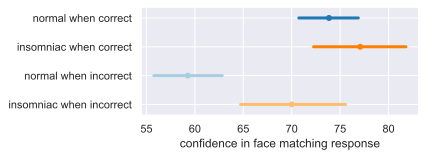

In [8]:
# Make plot of confidence intervals
ax = plot_conf_ints(
    [conf_corr_normal, conf_corr_insom, conf_incorr_normal, conf_incorr_insom],
    palette=['#1f77b3', '#ff7f00', '#a6cee3', '#fdbf6f']
)

_ = ax.set_xlabel("confidence in face matching response")

The evidence from this plot is clear. Insomniacs are more confident that they have provided a correct answer when they have not. The difference is about 10% on the confidence scale, which is about 20% of the entire range of responses from subjects about their confidence. If we were to perform the experiment again, we would very likely continue to see this discrepancy.

### Defining null hypothesis significance tests

We have already drawn telling conclusions from the data from the analysis above. Considering the confidence when incorrect, the rightward shift of the ECDF for insomniacs relative to normal sleepers strongly suggests the overconfidence of insomniacs. The confidence intervals make clear that this effect is not do to the inherent variability among participants and the small sample size. We really could conclude our analysis there.

Nonetheless, we will proceed to do a null hypothesis significance test. In some fields, this is referred to as an A/B test. I do so primarily because they are widely used and are important to know how to do and to interpret. I will give further commentary about why the results of NHST should not carry as much weight as conclusions derived from graphical EDA with ECDFs and calculation of confidence intervals.

I begin by reviewing what a NHST is. A typical hypothesis test consists of these steps.

1. Clearly state the hypothesis being considered, referred to as the **null hypothesis**.
2. Define a **test statistic**, a scalar value that you can compute from data, almost always a statistical functional of the empirical distribution. Compute it directly from your measured data.
3. *Simulate* data acquisition for the scenario where the null hypothesis is true. Do this many times, computing and storing the value of the test statistic each time.
4. The fraction of simulations for which the test statistic is at least as extreme as the test statistic computed from the measured data is called the **p-value**, which is what you report.

We need to be clear on our definition here. The p-value is the probability of observing a test statistic being at least as extreme as what was measured if the null hypothesis is true. It is exactly that, and nothing else. It is not the probability that the null hypothesis is true. In the frequentist interpretation of probability, we cannot assign a probability to the truth of a hypothesis.

A complete definition of a hypothesis test then has the following components.

- The null hypothesis
- The test statistic
- What it means to be at least as extreme. 

All of the named hypothesis tests you may have heard of, like the Student-t test, the Mann-Whitney U-test, Welch’s t-test, etc., describe a specific hypothesis with a specific test statistic with a specific definition of what it means to be at least as extreme (e.g., one-tailed or two-tailed). I can never remember what these are, nor do I encourage you to; you can always look them up. Rather, you should just clearly write out what your test is in terms of the hypothesis, test statistic, and definition of extremeness.

### **Performing a NHST**

To perform a hypothesis test using hacker stats, we will follow the prescription laid out above. We of course have to start by specifying our test.

- Null hypothesis: The generative distributions for reported confidence is the same for insomniacs as it is for normal sleepers.
- Test statistic: Mean confidence of normal sleepers minus that of insomniacs.
- At least as extreme as: The test statistic is less than or equal to the observed difference of means.

The bread and butter of conducting a hypothesis is simulating data acquisition under the null hypothesis. For this specific hypothesis, that the distributions are the same, there is a very straight-forward way of simulating it. Let `x` and `y` be our two arrays, with `m` entries in `x` and `n` entries in `y`.

1. Concatenate the two data sets into one. This is done with `np.concatenate((x, y))`.
2. Randomly scramble the order of the combined data set. This is accomplished using `np.random.permutation()`.
3. Designate the first `m` entries in this scrambled array to be "x" and the remaining to be "y."

We then use these new "x" and "y" arrays to compute the test statistic.

This simulation is exact; it is as if the label of the data set has no meaning; hence the distributions of the two data sets are entirely equal. Note that we are *not* say what the distribution is, only that the two data sets have the *same* distribution. 

A test done in this way is referred to as a **permutation test**. A **permutation sample** is akin to a bootstrap sample; it is a new pair of data sets generated after scrambling the concatenated data set. A **permutation replicate** is a value of the test statistic computed from a permutation sample, in this case the difference of means.

Let's code up the functions to do the test, starting with generating the permutation sample.

In [9]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

We need to provide a function that takes in two data sets (a permutation sample or the original data sets) and computes the test statistic. In our case, this is the difference of means.

In [10]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    return np.mean(data_1) - np.mean(data_2)

Finally, we can write a function to generate multiple permutation replicates.

In [11]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

We'll start with the confidence when giving correct answers to the face matching test for insomniacs versus normal sleepers. We start by computing the test statistic from the actual measurements.

In [12]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_corr_normal.data, conf_corr_insom.data)

# Take a look
test_stat

-3.22935064935065

Now, we'll draw permutation replicates.

In [13]:
# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_corr_normal.data, conf_corr_insom.data, diff_of_means, size=10000
)

Now, we'll see what fraction were less than or equal to the test statistic calculated from the measured data sets.

In [14]:
# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.1468

In this case, the p-value is about 0.16, which means that about 16% of the time, the null hypothesis that the confidence when correct for insomniacs and normal sleepers is the same will generate a difference of means at least as different in magnitude than what was observed. The data are then commensurate with the null hypothesis; they do not serve to rule out that hypothesis.

Now, let's do the same analysis for the case where the subjects responded incorrectly to the face matching test.

In [15]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_incorr_normal.data, conf_incorr_insom.data)

# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_incorr_normal.data, conf_incorr_insom.data, diff_of_means, size=10000
)

# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.002

This p-value is much smaller. Only 0.1 or 0.2% of the permutation samples had a difference of means less than or equal to what was observed. According to this result, it is unlikely that the observed data set could have been generated by identical distributions for normal sleepers and insomniacs. We did already know this from our analysis of the confidence intervals, and this is the icing on the cake.

### **Do not overemphasize NHSTs**

It is important to know exactly what an NHST gives you, a p-value. It is the probability of observing a test statistic being at least as extreme as what was measured if the null hypothesis is true. To put interpretation of the p-value versus plug-in estimates and confidence intervals, let's consider three questions addressed by these calculations.

1. **Plug-in estimate**: How different are the means of the two samples?
2. **Confidence interval**: If we were to do the experiments again, would we get similar results for our plug-in estimates?
3. **NHST**: What is the probability of observing a difference in means of the two samples at least as large as the observed difference in means, if the two samples in fact have the same generative distribution?

I contend that a person thinking about their data set might naturally ask the first two questions, but the third question is convoluted and of little practical interest.

To put this in perspective, say we made trillions of measurements of two different samples and their mean differs by one part per million. This difference, though tiny, would still give a low p-value, and therefore often be deemed "statistically significant." But, ultimately, it is the size of the difference, or the **effect size**, relative to the experiment-to-experiment variation, that we care about.

## **3. Correlation of sleep metrics**

For the next study of the data set, we will explore the correlations among the three sleep/drowsiness metrics. Remember that two variables are **correlated** if one is high while the other is high. They are anticorrelated if one is high while the other is low. And they are said to be uncorrelated if the level of one is not related to the level of the other.

We can do a quick exploration of the relationship between each pair of sleep indexes by making scatter plots of each pair of indexes. This is conveniently accomplished using seaborn's `pairplot()` function.

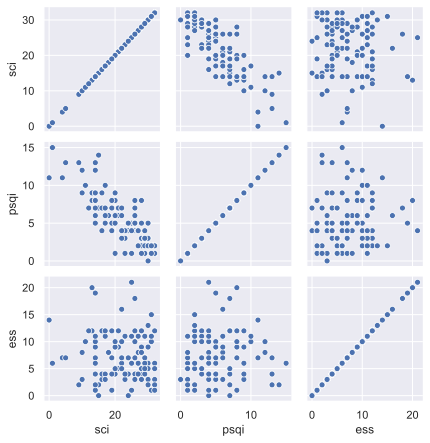

In [16]:
_ = sns.pairplot(df[['sci', 'psqi', 'ess']], diag_kind=None, height=2)

In glancing at these plots, the SCI and PSQI are clearly anticorrelated. This makes sense; they are both assess a similar feature of the subjects, the quality of nighttime sleep. Their scales are such that quality sleep is a hight number in the SCI and a low number in the PSQI, so we would expect them to be anticorrelated.

However, visually at least, the ESS does not seem to correlate with SCI or PQSI. Recall that ESS is a measure of daytime drowsiness. We might expect that to correlate with sleep quality, but it does not seem to, at least graphically (though the analysis we will soon do may show that it does). Previous studies (e.g., [this one](http://dx.doi.org/10.1016/j.smrv.2009.04.002)) have shown that insomniacs experience hyperarousal, meaning that they are not drowsy as a result of their poor sleep. This would suggest that we should not be surprised by a lack of correlation between SCI and ESS.

### **Plug-in estimate for correlation**

With the graphical analysis out of the way, let's investigate the Pearson correlation between the pairs of metrics. We can compute the plug-in estimate using `np.corrcoef()`, first extracting the data as NumPy arrays. Remember that the Pearson correlation is 1 for perfect correlation and –1 for perfect anticorrelation.

In [17]:
# Extract all three sleep/drowsiness metrics as NumPy arrays
sci = df['sci'].dropna().values
psqi = df['psqi'].dropna().values
ess = df['ess'].dropna().values

# Compute Pearson correlation between each pair
rho_sci_psqi = np.corrcoef(sci, psqi)[0, 1]
rho_sci_ess = np.corrcoef(sci, ess)[0, 1]
rho_psqi_ess = np.corrcoef(psqi, ess)[0, 1]

# Print the result
print('plug-in SCI-PSQI correlation:', rho_sci_psqi)
print('plug-in SCI-ESS correlation: ', rho_sci_ess)
print('plug-in PSQI-ESS correlation:', rho_psqi_ess)

plug-in SCI-PSQI correlation: -0.8366404153156871
plug-in SCI-ESS correlation:  -0.08930808942621958
plug-in PSQI-ESS correlation: 0.06160925920530207


Indeed, the SCI and PSQI are strongly anticorrelated, but the SCI and PSQI are not really correlated with ESS.

### **Bootstrap confidence intervals for correlation**

Introduce pairs bootstrap.

In [18]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates


def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

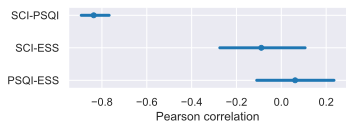

In [19]:
# Pairs bootstrap replicates of correlation
sci_psqi_reps = draw_bs_pairs(sci, psqi, pearson_r, size=10000)
sci_ess_reps = draw_bs_pairs(sci, ess, pearson_r, size=10000)
psqi_ess_reps = draw_bs_pairs(psqi, ess, pearson_r, size=10000)

# Pairs bootstrap confidence intervals
sci_psqi_conf_int = np.percentile(sci_psqi_reps, [2.5, 97.5])
sci_ess_conf_int = np.percentile(sci_ess_reps, [2.5, 97.5])
psqi_ess_conf_int = np.percentile(psqi_ess_reps, [2.5, 97.5])

# Toss into class
class Generic(object):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)


sci_psqi_res = Generic(
    category="SCI-PSQI", estimate=rho_sci_psqi, conf_int=sci_psqi_conf_int,
)
sci_ess_res = Generic(
    category="SCI-ESS", estimate=rho_sci_ess, conf_int=sci_ess_conf_int,
)
psqi_ess_res = Generic(
    category="PSQI-ESS", estimate=rho_psqi_ess, conf_int=psqi_ess_conf_int,
)

# Make plot
_ = plot_conf_ints(
    [sci_psqi_res, sci_ess_res, psqi_ess_res], palette="#1f77b3",
)
_ = plt.xlabel("Pearson correlation")

There is very clearly strong correlation between SCI and PSQI, but no real correlation between those metrics and the ESS metric for daytime drowsiness.

## **4. Effect of drowsiness on performance**

Important to point out here that we will use a linear regression here, since we're trying to use drowsiness to explain performance.

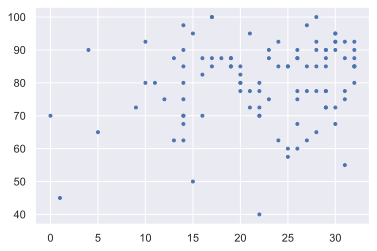

In [20]:
_ = plt.plot(df['sci'], df['percent correct'], marker='.', linestyle='none')

In [21]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


In [22]:
ess = df['ess'].dropna().values
pcorr = df['percent correct'].dropna().values

bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(ess, pcorr, size=10000)

np.percentile(bs_slope_reps, [2.5, 97.5])

array([-0.73234502,  0.27555068])

There is a slight negative slope, but it could be close to zero. Can do hypothesis test. Scramble ESS measurements, compute slope, check if more extreme than observed.

In [23]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def slope(data_1, data_2):
    """Compute slope from linear regression"""
    return np.polyfit(data_1, data_2, 1)[0]


perm_reps = draw_perm_reps(ess, pcorr, slope, size=10000)

# p-value
np.sum(perm_reps >= slope(ess, pcorr)) / 10000

0.9824

## **Further study**

- Does performance in the tests correlate with age? How about confidence?
- Do we see gender differences in performance? How about confidence?

Finally, I'll note that we also import [dc_stat_think](https://github.com/justinbois/dc_stat_think) as `dcst`. This is a package that contains all of the functions that learners wrote in the Statistical Thinking courses (including Case Studies in Statistical Thinking). We will use it directly until the very end, since it will be good practice here to go over how those functions are constructed.